# **Circadian Rhythm and Well-being Analysis Project**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/content/circadian_mental_health_data.csv")

In [4]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")

In [5]:
print(df.head())

   Participant_ID       Date  Sleep_Start_Time  Wake_Time  Sleep_Duration  \
0               1 2024-01-07         23.090350  31.504955        8.414606   
1               1 2024-01-09         23.623777  32.797525        9.173748   
2               1 2024-01-22         23.735638  29.955347        6.219709   
3               1 2024-02-05         23.390755  29.730430        6.339675   
4               1 2024-02-07         23.470210  31.151717        7.681507   

   Mid_Sleep_Time    Chronotype  Social_Jetlag  Mood_Score  Stress_Score  \
0       27.297653  Intermediate       0.347535    6.441809      3.374887   
1       28.210651  Intermediate       0.000000    4.964310      6.073682   
2       26.845492  Intermediate       0.000000    3.636436      5.050843   
3       26.560593  Intermediate       0.000000    4.216680      4.099884   
4       27.310964  Intermediate       0.000000    5.390784      5.023751   

   Anxiety_Score  Exercise_Duration  Screen_Time  
0       7.205910          16.

In [6]:
print("Shape:", df.shape)

Shape: (9000, 13)


# **How are participants distributed across chronotype categories?**

In [8]:
# Chronotype counts and percentages
counts = df["Chronotype"].value_counts()
percentages = df["Chronotype"].value_counts(normalize=True) * 100
print("Counts:\n", counts)
print("\nPercentages:\n", percentages)

Counts:
 Chronotype
Intermediate    4080
Early Bird      2540
Night Owl       2380
Name: count, dtype: int64

Percentages:
 Chronotype
Intermediate    45.333333
Early Bird      28.222222
Night Owl       26.444444
Name: proportion, dtype: float64


# **How much circadian misalignment (social jetlag) is observed in the population?**

In [12]:
# Mean social jetlag per participant
sj_by_participant = df.groupby("Participant_ID")["Social_Jetlag"].mean()
mean_sj = sj_by_participant.mean()
perc_high_sj = (sj_by_participant > 2).mean() * 100

print(f"Mean Social Jetlag: {mean_sj:.2f} hours")
print(f"Participants with >2h Social Jetlag: {perc_high_sj:.1f}%")

Mean Social Jetlag: 0.35 hours
Participants with >2h Social Jetlag: 0.0%


# **What are the relationships among sleep timing, duration, social jetlag, mood, stress, and anxiety?**

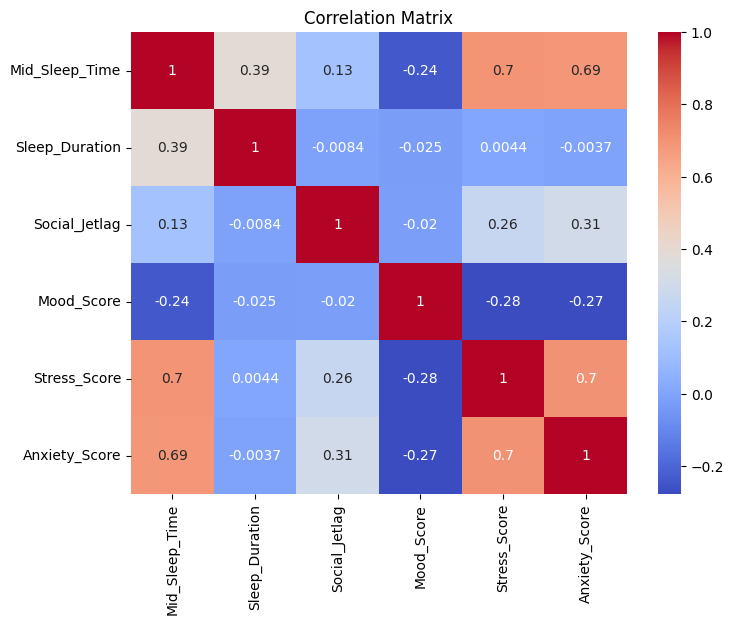

In [13]:
corr_matrix = df[[
    "Mid_Sleep_Time",
    "Sleep_Duration",
    "Social_Jetlag",
    "Mood_Score",
    "Stress_Score",
    "Anxiety_Score"
]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# **Do mental health scores differ significantly across chronotypes?**

Means:
               Anxiety_Score  Stress_Score  Mood_Score
Chronotype                                           
Early Bird         3.163016      3.115493    5.245462
Intermediate       5.134371      5.121518    4.826686
Night Owl          7.287441      7.242562    4.406329

Standard Deviations:
               Anxiety_Score  Stress_Score  Mood_Score
Chronotype                                           
Early Bird         1.047106      1.022443    1.059877
Intermediate       1.023388      1.016115    1.052054
Night Owl          1.107675      1.070074    1.067735


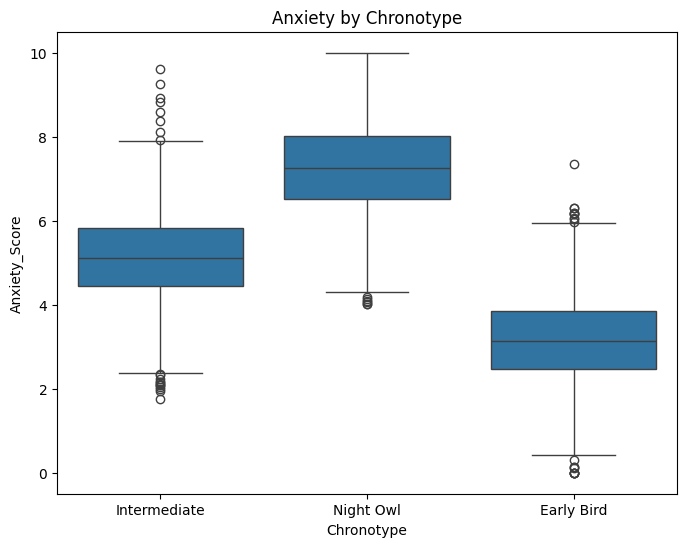

In [14]:
# Means and std by chronotype
means = df.groupby("Chronotype")[["Anxiety_Score","Stress_Score","Mood_Score"]].mean()
stds = df.groupby("Chronotype")[["Anxiety_Score","Stress_Score","Mood_Score"]].std()

print("Means:\n", means)
print("\nStandard Deviations:\n", stds)

# Boxplot example for Anxiety
plt.figure(figsize=(8,6))
sns.boxplot(x="Chronotype", y="Anxiety_Score", data=df)
plt.title("Anxiety by Chronotype")
plt.show()

# **Does later sleep timing on one night predict worse anxiety the next day?**

In [15]:
# Sort by participant and date
df = df.sort_values(["Participant_ID","Date"])

# Lag sleep start time
df["Prev_Sleep_Start"] = df.groupby("Participant_ID")["Sleep_Start_Time"].shift(1)

# Correlation between previous sleep start and current anxiety
lagged = df.dropna(subset=["Prev_Sleep_Start","Anxiety_Score"])
lag_corr = np.corrcoef(lagged["Prev_Sleep_Start"], lagged["Anxiety_Score"])[0,1]

print(f"Lag Correlation: {lag_corr:.2f}")

Lag Correlation: 0.75


# **How do mid-sleep time, social jetlag, and their interaction predict anxiety?**

In [16]:
# Center variables
df["Mid_Centered"] = df["Mid_Sleep_Time"] - df["Mid_Sleep_Time"].mean()
df["SJ_Centered"] = df["Social_Jetlag"] - df["Social_Jetlag"].mean()
df["Interaction"] = df["Mid_Centered"] * df["SJ_Centered"]

X = df[["Mid_Centered","SJ_Centered","Interaction"]].values
y = df["Anxiety_Score"].values

# Add intercept
X = np.column_stack([np.ones(X.shape[0]), X])

# OLS regression
beta = np.linalg.lstsq(X, y, rcond=None)[0]

print("Regression Coefficients:")
print(f"Intercept: {beta[0]:.3f}")
print(f"Mid Sleep: {beta[1]:.3f}")
print(f"Social Jetlag: {beta[2]:.3f}")
print(f"Interaction: {beta[3]:.3f}")

Regression Coefficients:
Intercept: 5.148
Mid Sleep: 0.926
Social Jetlag: 0.655
Interaction: -0.006


# **How do anxiety and social jetlag distributions differ by chronotype?**

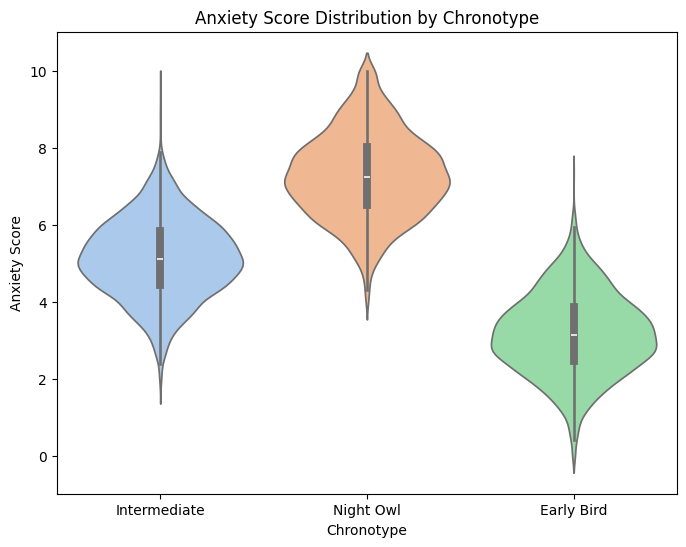

In [20]:
plt.figure(figsize=(8,6))
sns.violinplot(x="Chronotype", y="Anxiety_Score", hue="Chronotype", data=df, palette="pastel", legend=False)
plt.title("Anxiety Score Distribution by Chronotype")
plt.xlabel("Chronotype")
plt.ylabel("Anxiety Score")
plt.show()

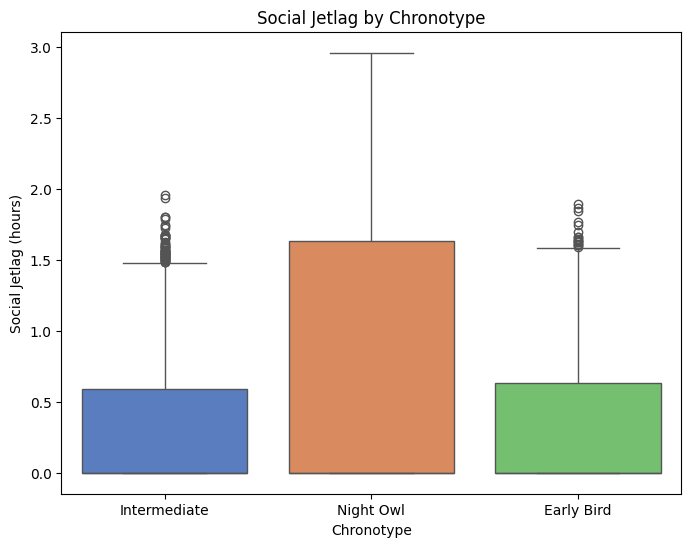

In [21]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Chronotype", y="Social_Jetlag", hue="Chronotype", data=df, palette="muted", legend=False)
plt.title("Social Jetlag by Chronotype")
plt.xlabel("Chronotype")
plt.ylabel("Social Jetlag (hours)")
plt.show()

# **How does mood vary across the week?**

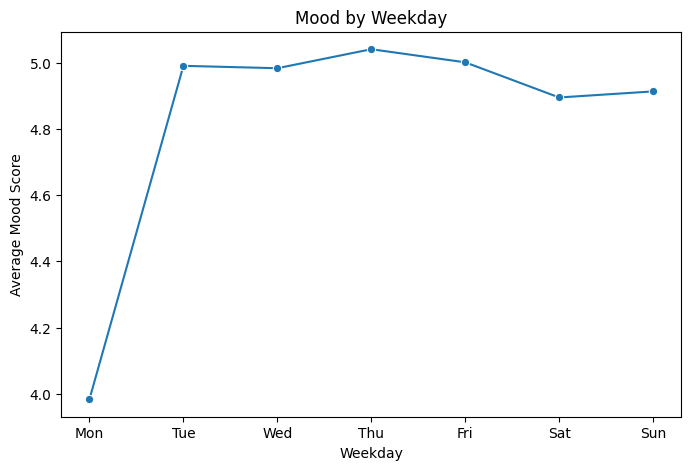

In [22]:
# Weekday extraction
df["Weekday"] = df["Date"].dt.weekday

# Mean mood per weekday
mood_weekday = df.groupby("Weekday")["Mood_Score"].mean()

plt.figure(figsize=(8,5))
sns.lineplot(x=mood_weekday.index, y=mood_weekday.values, marker="o")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Mood by Weekday")
plt.ylabel("Average Mood Score")
plt.show()

# **Is the relationship between Mid Sleep Time and Anxiety independent of Sleep Duration?**

In [25]:
# Center Sleep Duration
sleep_dur = df["Sleep_Duration"].values
mid_sleep = df["Mid_Sleep_Time"].values
anxiety = df["Anxiety_Score"].values

# Regress Mid Sleep on Sleep Duration (manual residuals)
A = np.vstack([np.ones(len(sleep_dur)), sleep_dur]).T
beta_mid = np.linalg.lstsq(A, mid_sleep, rcond=None)[0]
resid_mid = mid_sleep - A @ beta_mid

# Regress Anxiety on Sleep Duration (manual residuals)
beta_anx = np.linalg.lstsq(A, anxiety, rcond=None)[0]
resid_anx = anxiety - A @ beta_anx

# Correlation between residuals
partial_corr = np.corrcoef(resid_mid, resid_anx)[0,1]
print(f"Partial Correlation (Mid Sleep ↔ Anxiety controlling for Sleep Duration): {partial_corr:.2f}")

Partial Correlation (Mid Sleep ↔ Anxiety controlling for Sleep Duration): 0.75
